In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f4ac5265ce8150bf13806a3fd0c509a90a6b7c045b4ba142d9485d1c5743efc6
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def prepare_data_with_dim_reduction(features, target, method="pca", n_components=None, sequence_length=30):
    """
    Prepares LSTM sequences after applying PCA or FDA for dimensionality reduction.

    Parameters:
        features (numpy.ndarray): Scaled feature matrix.
        target (numpy.ndarray): Target array (rise/fall labels).
        method (str): Dimensionality reduction method ("pca" or "fda").
        n_components (int): Number of components to retain (for PCA only).
        sequence_length (int): Number of past days to include in each LSTM sequence.

    Returns:
        X (numpy.ndarray): LSTM input sequences.
        y (numpy.ndarray): LSTM target values.
    """
    if method == "pca":
        # Apply PCA
        pca = PCA(n_components=n_components)  # If n_components is None, PCA decides
        reduced_features = pca.fit_transform(features)
        print(f"PCA: Retained {pca.n_components_} components explaining {sum(pca.explained_variance_ratio_):.2%} of variance.")

    elif method == "fda":
        # Apply Fisher Discriminant Analysis
        fda = LinearDiscriminantAnalysis()
        reduced_features = fda.fit_transform(features, target)
        print(f"FDA: Reduced features to {reduced_features.shape[1]} dimensions.")

    else:
        raise ValueError("Invalid method. Choose 'pca' or 'fda'.")

    # Prepare LSTM sequences
    X, y = [], []
    for i in range(len(reduced_features) - sequence_length):
        X.append(reduced_features[i:i + sequence_length])
        y.append(target[i + sequence_length])

    return np.array(X), np.array(y)

def create_sequences(features, target, sequence_length):
    # Trim target to match the length of sequences
    valid_length = len(features) - sequence_length
    features = features[:valid_length + sequence_length]  # Trim features to valid length
    target = target[:valid_length]  # Ensure target aligns with sequences

    X, y = [], []
    for i in range(valid_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i])  # Directly use the corresponding target
    return np.array(X), np.array(y)

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import ta
import matplotlib.pyplot as plt

# Step 1: Data Collection
dow_jones = yf.download('^DJI', start="2012-01-01", end="2023-01-01")  # Dow Jones
sp500 = yf.download('^GSPC', start="2012-01-01", end="2023-01-01")  # S&P 500

uvxy = yf.download('UVXY', start="2012-01-01", end="2023-01-01")
vix = yf.download('^VIX', start="2012-01-01", end="2023-01-01")

# Flatten MultiIndex columns if necessary
if isinstance(dow_jones.columns, pd.MultiIndex):
    dow_jones.columns = ['_'.join(col).strip() for col in dow_jones.columns.values]
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = ['_'.join(col).strip() for col in sp500.columns.values]
if isinstance(uvxy.columns, pd.MultiIndex):
    uvxy.columns = ['_'.join(col).strip() for col in uvxy.columns.values]
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = ['_'.join(col).strip() for col in vix.columns.values]

# Select and rename relevant columns
uvxy_close_col = 'Close_UVXY' if 'Close_UVXY' in uvxy.columns else 'Adj Close_UVXY'
vix_close_col = 'Close_^VIX' if 'Close_^VIX' in vix.columns else 'Adj Close_^VIX'

uvxy = uvxy[[uvxy_close_col]].rename(columns={uvxy_close_col: 'UVXY_Close'})
vix = vix[[vix_close_col]].rename(columns={vix_close_col: 'VIX_Close'})

# Merge UVXY and VIX data with NASDAQ data
dow_jones = dow_jones.merge(uvxy, left_index=True, right_index=True, how='inner')
dow_jones = dow_jones.merge(vix, left_index=True, right_index=True, how='inner')

sp500 = sp500.merge(uvxy, left_index=True, right_index=True, how='inner')
sp500 = sp500.merge(vix, left_index=True, right_index=True, how='inner')

# Rename NASDAQ columns for easier reference
# Rename columns for easier reference
def rename_columns(df, prefix):
    return df.rename(columns={
        'Open_^DJI': f'Open_{prefix}',
        'High_^DJI': f'High_{prefix}',
        'Low_^DJI': f'Low_{prefix}',
        'Close_^DJI': f'Close_{prefix}',
        'Volume_^DJI': f'Volume_{prefix}',
        'Open_^GSPC': f'Open_{prefix}',
        'High_^GSPC': f'High_{prefix}',
        'Low_^GSPC': f'Low_{prefix}',
        'Close_^GSPC': f'Close_{prefix}',
        'Volume_^GSPC': f'Volume_{prefix}'
    }, inplace=False)

dow_jones = rename_columns(dow_jones, 'DowJones')
sp500 = rename_columns(sp500, 'SP500')

# Ensure no missing values after merging
dow_jones['UVXY_Close'] = pd.to_numeric(dow_jones['UVXY_Close'], errors='coerce').ffill().bfill()
dow_jones['VIX_Close'] = pd.to_numeric(dow_jones['VIX_Close'], errors='coerce').ffill().bfill()

sp500['UVXY_Close'] = pd.to_numeric(sp500['UVXY_Close'], errors='coerce').ffill().bfill()
sp500['VIX_Close'] = pd.to_numeric(sp500['VIX_Close'], errors='coerce').ffill().bfill()

# Step 2: Feature Preparation and Scaling
# Features for Model 1 (OHLCV + UVXY + VIX)
# Dow Jones
features_ohlcv_uvxy_vix = ['Open_DowJones', 'High_DowJones', 'Low_DowJones', 'Close_DowJones', 'Volume_DowJones', 'UVXY_Close', 'VIX_Close']
scaler_featureModel1_dow = MinMaxScaler()
scaled_features_ohlcv_dow = scaler_featureModel1_dow.fit_transform(dow_jones[features_ohlcv_uvxy_vix])

# S&P 500
features_ohlcv_uvxy_vix_sp500 = ['Open_SP500', 'High_SP500', 'Low_SP500', 'Close_SP500', 'Volume_SP500', 'UVXY_Close', 'VIX_Close']
scaler_featureModel1_sp500 = MinMaxScaler()
scaled_features_ohlcv_sp500 = scaler_featureModel1_sp500.fit_transform(sp500[features_ohlcv_uvxy_vix_sp500])

# Features for Model 2 (Technical Indicators)
dow_jones['RSI'] = ta.momentum.RSIIndicator(dow_jones['Close_DowJones'], window=14).rsi()
dow_jones['MACD'] = ta.trend.MACD(dow_jones['Close_DowJones']).macd()
bollinger = ta.volatility.BollingerBands(dow_jones['Close_DowJones'])
dow_jones['Bollinger_Upper'] = bollinger.bollinger_hband()
dow_jones['Bollinger_Lower'] = bollinger.bollinger_lband()
dow_jones['Volatility'] = dow_jones['Close_DowJones'].rolling(window=20).std()

features_tech = ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
dow_jones.dropna(inplace=True)
scaler_featureModel2_tech_dow = MinMaxScaler()
scaled_featuresModel2_tech_dow = scaler_featureModel2_tech_dow.fit_transform(dow_jones[features_tech])

# Generate Technical Indicators for S&P 500
sp500['RSI'] = ta.momentum.RSIIndicator(sp500['Close_SP500'], window=14).rsi()
sp500['MACD'] = ta.trend.MACD(sp500['Close_SP500']).macd()
bollinger_sp500 = ta.volatility.BollingerBands(sp500['Close_SP500'])
sp500['Bollinger_Upper'] = bollinger_sp500.bollinger_hband()
sp500['Bollinger_Lower'] = bollinger_sp500.bollinger_lband()
sp500['Volatility'] = sp500['Close_SP500'].rolling(window=20).std()

# Technical features for S&P 500
features_tech_sp500 = ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
sp500.dropna(inplace=True)

# Scale the technical indicators
scaler_featureModel2_tech_sp500 = MinMaxScaler()
scaled_featuresModel2_tech_sp500 = scaler_featureModel2_tech_sp500.fit_transform(sp500[features_tech_sp500])

# Features for gates
# Shared features for Dow Jones
shared_features_dow = ['Open_DowJones', 'High_DowJones', 'Low_DowJones', 'Close_DowJones', 'Volume_DowJones',
                       'UVXY_Close', 'VIX_Close', 'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
scaler_featureGate_dow = MinMaxScaler()
scaled_features_gate_dow = scaler_featureGate_dow.fit_transform(dow_jones[shared_features_dow])

# Shared features for S&P 500
shared_features_sp500 = ['Open_SP500', 'High_SP500', 'Low_SP500', 'Close_SP500', 'Volume_SP500',
                         'UVXY_Close', 'VIX_Close', 'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
scaler_featureGate_sp500 = MinMaxScaler()
scaled_features_gate_sp500 = scaler_featureGate_sp500.fit_transform(sp500[shared_features_sp500])

# Target variable for Dow Jones
dow_jones['Target'] = dow_jones['Close_DowJones'].shift(-5).rolling(window=5, min_periods=1).mean()
dow_jones.dropna(subset=['Target'], inplace=True)
scaler_y_dow = MinMaxScaler()
dow_jones['Target'] = scaler_y_dow.fit_transform(dow_jones[['Target']])

# Target variable for S&P 500
sp500['Target'] = sp500['Close_SP500'].shift(-5).rolling(window=5, min_periods=1).mean()
sp500.dropna(subset=['Target'], inplace=True)
scaler_y_sp500 = MinMaxScaler()
sp500['Target'] = scaler_y_sp500.fit_transform(sp500[['Target']])


# Step 3: Create Sequences
sequence_length = 30

def create_sequences(features, target, sequence_length):
    valid_length = min(len(features), len(target)) - sequence_length
    features = features[:valid_length + sequence_length]
    target = target[:valid_length]

    X, y = [], []
    for i in range(valid_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i])
    return np.array(X), np.array(y)

# Sequences for Dow Jones
X_ohlcv_dow, y_dow = create_sequences(scaled_features_ohlcv_dow, dow_jones['Target'].values, sequence_length)
X_tech_dow, _ = create_sequences(scaled_featuresModel2_tech_dow, dow_jones['Target'].values, sequence_length)
X_gate_dow, _ = create_sequences(scaled_features_gate_dow, dow_jones['Target'].values, sequence_length)

# Sequences for S&P 500
X_ohlcv_sp500, y_sp500 = create_sequences(scaled_features_ohlcv_sp500, sp500['Target'].values, sequence_length)
X_tech_sp500, _ = create_sequences(scaled_featuresModel2_tech_sp500, sp500['Target'].values, sequence_length)
X_gate_sp500, _ = create_sequences(scaled_features_gate_sp500, sp500['Target'].values, sequence_length)

# Train-test split for Dow Jones
split_index_dow = int(0.8 * len(X_ohlcv_dow))
X_train1_dow, X_test1_dow = X_ohlcv_dow[:split_index_dow], X_ohlcv_dow[split_index_dow:]
X_train2_dow, X_test2_dow = X_tech_dow[:split_index_dow], X_tech_dow[split_index_dow:]
X_GateTrain_dow, X_GateTest_dow = X_gate_dow[:split_index_dow], X_gate_dow[split_index_dow:]
y_train_dow, y_test_dow = y_dow[:split_index_dow], y_dow[split_index_dow:]

val_split_index_dow = int(0.9 * len(X_train1_dow))
X_val1_dow, y_val_dow = X_train1_dow[val_split_index_dow:], y_train_dow[val_split_index_dow:]
X_train1_dow, y_train_dow = X_train1_dow[:val_split_index_dow], y_train_dow[:val_split_index_dow]

X_val2_dow = X_train2_dow[val_split_index_dow:]
X_train2_dow = X_train2_dow[:val_split_index_dow]

# Train-test split for S&P 500
split_index_sp500 = int(0.8 * len(X_ohlcv_sp500))
X_train1_sp500, X_test1_sp500 = X_ohlcv_sp500[:split_index_sp500], X_ohlcv_sp500[split_index_sp500:]
X_train2_sp500, X_test2_sp500 = X_tech_sp500[:split_index_sp500], X_tech_sp500[split_index_sp500:]
X_GateTrain_sp500, X_GateTest_sp500 = X_gate_sp500[:split_index_sp500], X_gate_sp500[split_index_sp500:]
y_train_sp500, y_test_sp500 = y_sp500[:split_index_sp500], y_sp500[split_index_sp500:]

val_split_index_sp500 = int(0.9 * len(X_train1_sp500))
X_val1_sp500, y_val_sp500 = X_train1_sp500[val_split_index_sp500:], y_train_sp500[val_split_index_sp500:]
X_train1_sp500, y_train_sp500 = X_train1_sp500[:val_split_index_sp500], y_train_sp500[:val_split_index_sp500]

X_val2_sp500 = X_train2_sp500[val_split_index_sp500:]
X_train2_sp500 = X_train2_sp500[:val_split_index_sp500]

# Step 4: Define LSTM Models
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(100, return_sequences=False),
        Dropout(0.3),
        Dense(1, activation='linear')  # Linear activation for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Define and train LSTM models for Dow Jones
model1_dow = create_lstm_model((X_train1_dow.shape[1], X_train1_dow.shape[2]))
model2_dow = create_lstm_model((X_train2_dow.shape[1], X_train2_dow.shape[2]))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_model1_dow = model1_dow.fit(X_train1_dow, y_train_dow, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
history_model2_dow = model2_dow.fit(X_train2_dow, y_train_dow, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

# Define and train LSTM models for S&P 500
model1_sp500 = create_lstm_model((X_train1_sp500.shape[1], X_train1_sp500.shape[2]))
model2_sp500 = create_lstm_model((X_train2_sp500.shape[1], X_train2_sp500.shape[2]))

history_model1_sp500 = model1_sp500.fit(X_train1_sp500, y_train_sp500, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
history_model2_sp500 = model2_sp500.fit(X_train2_sp500, y_train_sp500, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

# Define Gating Network
gating_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_GateTrain_sp500.shape[1], X_GateTrain_sp500.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(2, activation='softmax')  # Two outputs: weights for Model 1 and Model 2
])
gating_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Models for Dow Jones
history_model1_dow = model1_dow.fit(X_train1_dow, y_train_dow, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
history_model2_dow = model2_dow.fit(X_train2_dow, y_train_dow, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

# Predictions on training data
pred1_train_dow = model1_dow.predict(X_train1_dow)
pred2_train_dow = model2_dow.predict(X_train2_dow)

# Inverse transform to get original scale
y_train_original_dow = scaler_y_dow.inverse_transform(y_train_dow.reshape(-1, 1))
pred1_train_original_dow = scaler_y_dow.inverse_transform(pred1_train_dow)
pred2_train_original_dow = scaler_y_dow.inverse_transform(pred2_train_dow)

# Calculate errors for weighting
error1_dow = np.abs(pred1_train_original_dow - y_train_original_dow)
error2_dow = np.abs(pred2_train_original_dow - y_train_original_dow)

# Convert errors to weights (inverse of error, normalized)
weights1_dow = 1 / (error1_dow + 1e-6)  # Adding a small constant to avoid division by zero
weights2_dow = 1 / (error2_dow + 1e-6)
sum_weights_dow = weights1_dow + weights2_dow
weights1_normalized_dow = weights1_dow / sum_weights_dow
weights2_normalized_dow = weights2_dow / sum_weights_dow

# Gating network labels
y_gating_train_dow = np.hstack([weights1_normalized_dow, weights2_normalized_dow])

# Train gating network
history_gateModel_dow = gating_model.fit(
    X_GateTrain_dow[:val_split_index_dow], y_gating_train_dow, epochs=50, batch_size=32, validation_split=0.1,
    callbacks=[early_stopping], verbose=0
)

# Test the gating network
pred1_test_dow = model1_dow.predict(X_test1_dow)
pred2_test_dow = model2_dow.predict(X_test2_dow)
gating_weights_test_dow = gating_model.predict(X_GateTest_dow)

# Combine predictions using gating network weights
final_predictions_dow = gating_weights_test_dow[:, 0:1] * pred1_test_dow + gating_weights_test_dow[:, 1:2] * pred2_test_dow

# Inverse transform test predictions
predictions_original_dow = scaler_y_dow.inverse_transform(final_predictions_dow)
y_test_original_dow = scaler_y_dow.inverse_transform(y_test_dow.reshape(-1, 1))

# Train Models for S&P 500
history_model1_sp500 = model1_sp500.fit(X_train1_sp500, y_train_sp500, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
history_model2_sp500 = model2_sp500.fit(X_train2_sp500, y_train_sp500, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

# Predictions on training data
pred1_train_sp500 = model1_sp500.predict(X_train1_sp500)
pred2_train_sp500 = model2_sp500.predict(X_train2_sp500)

# Inverse transform to get original scale
y_train_original_sp500 = scaler_y_sp500.inverse_transform(y_train_sp500.reshape(-1, 1))
pred1_train_original_sp500 = scaler_y_sp500.inverse_transform(pred1_train_sp500)
pred2_train_original_sp500 = scaler_y_sp500.inverse_transform(pred2_train_sp500)

# Calculate errors for weighting
error1_sp500 = np.abs(pred1_train_original_sp500 - y_train_original_sp500)
error2_sp500 = np.abs(pred2_train_original_sp500 - y_train_original_sp500)

# Convert errors to weights (inverse of error, normalized)
weights1_sp500 = 1 / (error1_sp500 + 1e-6)  # Adding a small constant to avoid division by zero
weights2_sp500 = 1 / (error2_sp500 + 1e-6)
sum_weights_sp500 = weights1_sp500 + weights2_sp500
weights1_normalized_sp500 = weights1_sp500 / sum_weights_sp500
weights2_normalized_sp500 = weights2_sp500 / sum_weights_sp500

# Gating network labels
y_gating_train_sp500 = np.hstack([weights1_normalized_sp500, weights2_normalized_sp500])

# Train gating network
history_gateModel_sp500 = gating_model.fit(
    X_GateTrain_sp500[:val_split_index_sp500], y_gating_train_sp500, epochs=50, batch_size=32, validation_split=0.1,
    callbacks=[early_stopping], verbose=0
)

# Test the gating network
pred1_test_sp500 = model1_sp500.predict(X_test1_sp500)
pred2_test_sp500 = model2_sp500.predict(X_test2_sp500)
gating_weights_test_sp500 = gating_model.predict(X_GateTest_sp500)

# Combine predictions using gating network weights
final_predictions_sp500 = gating_weights_test_sp500[:, 0:1] * pred1_test_sp500 + gating_weights_test_sp500[:, 1:2] * pred2_test_sp500

# Inverse transform test predictions
predictions_original_sp500 = scaler_y_sp500.inverse_transform(final_predictions_sp500)
y_test_original_sp500 = scaler_y_sp500.inverse_transform(y_test_sp500.reshape(-1, 1))


mse_dow = mean_squared_error(y_test_original_dow, predictions_original_dow)
rmse_dow = np.sqrt(mse_dow)
r2_dow = r2_score(y_test_original_dow, predictions_original_dow)
mae_dow = mean_absolute_error(y_test_original_dow, predictions_original_dow)

print(f"Dow Jones - R²: {r2_dow:.4f}, MAE: {mae_dow:.4f}, MSE: {mse_dow:.4f}, RMSE: {rmse_dow:.4f}")


mse_sp500 = mean_squared_error(y_test_original_sp500, predictions_original_sp500)
rmse_sp500 = np.sqrt(mse_sp500)
r2_sp500 = r2_score(y_test_original_sp500, predictions_original_sp500)
mae_sp500 = mean_absolute_error(y_test_original_sp500, predictions_original_sp500)

print(f"S&P 500 - R²: {r2_sp500:.4f}, MAE: {mae_sp500:.4f}, MSE: {mse_sp500:.4f}, RMSE: {rmse_sp500:.4f}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Dow Jones - R²: 0.3711, MAE: 1720.4134, MSE: 3234187.6854, RMSE: 1798.3847
S&P 500 - R²: 0.8517, MAE: 121.6188, MSE: 19120.7904, RMSE: 138.2779


In [4]:
# Compute MAPE for Dow Jones
mape_dow = np.mean(np.abs((y_test_original_dow - predictions_original_dow) / y_test_original_dow)) * 100

# Compute DPA for Dow Jones
real_direction_dow = np.sign(np.diff(y_test_original_dow.ravel()))  # Actual price movement direction
predicted_direction_dow = np.sign(np.diff(predictions_original_dow.ravel()))  # Predicted price movement direction
correct_directions_dow = real_direction_dow == predicted_direction_dow
dpa_dow = np.sum(correct_directions_dow) / len(correct_directions_dow) * 100

# Compute MAPE for S&P 500
mape_sp500 = np.mean(np.abs((y_test_original_sp500 - predictions_original_sp500) / y_test_original_sp500)) * 100

# Compute DPA for S&P 500
real_direction_sp500 = np.sign(np.diff(y_test_original_sp500.ravel()))  # Actual price movement direction
predicted_direction_sp500 = np.sign(np.diff(predictions_original_sp500.ravel()))  # Predicted price movement direction
correct_directions_sp500 = real_direction_sp500 == predicted_direction_sp500
dpa_sp500 = np.sum(correct_directions_sp500) / len(correct_directions_sp500) * 100

# Print Metrics
print("Dow Jones Metrics:")
print(f"R² Score: {r2_dow:.4f}")
print(f"Mean Absolute Error (MAE): {mae_dow:.4f}")
print(f"Mean Squared Error (MSE): {mse_dow:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_dow:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dow:.2f}%")
print(f"Directional Percentage of Accuracy (DPA): {dpa_dow:.2f}%")

print("\nS&P 500 Metrics:")
print(f"R² Score: {r2_sp500:.4f}")
print(f"Mean Absolute Error (MAE): {mae_sp500:.4f}")
print(f"Mean Squared Error (MSE): {mse_sp500:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_sp500:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sp500:.2f}%")
print(f"Directional Percentage of Accuracy (DPA): {dpa_sp500:.2f}%")


Dow Jones Metrics:
R² Score: 0.3711
Mean Absolute Error (MAE): 1720.4134
Mean Squared Error (MSE): 3234187.6854
Root Mean Squared Error (RMSE): 1798.3847
Mean Absolute Percentage Error (MAPE): 5.16%
Directional Percentage of Accuracy (DPA): 76.20%

S&P 500 Metrics:
R² Score: 0.8517
Mean Absolute Error (MAE): 121.6188
Mean Squared Error (MSE): 19120.7904
Root Mean Squared Error (RMSE): 138.2779
Mean Absolute Percentage Error (MAPE): 2.86%
Directional Percentage of Accuracy (DPA): 75.28%


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Dow Jones - R²: 0.9827, MAE: 281.4451, MSE: 131146.9775, RMSE: 362.1422
MAPE: 0.76%
DPA: 76.37%


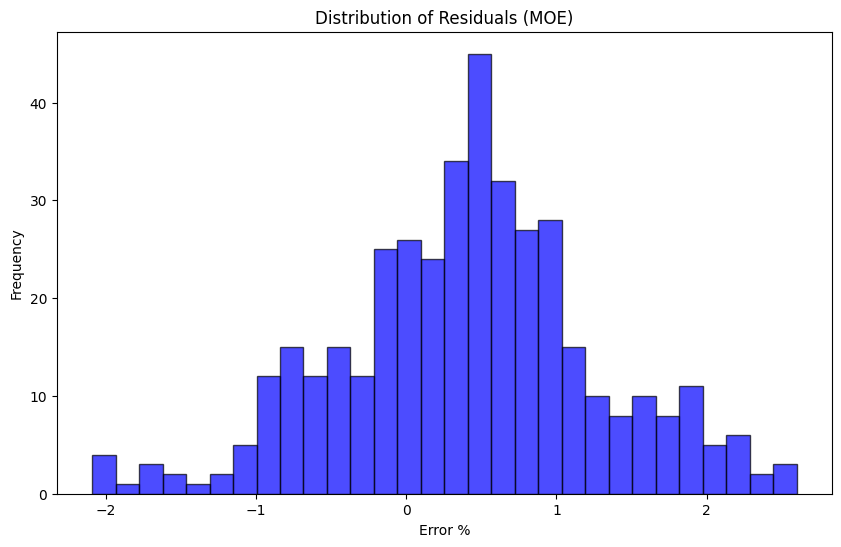

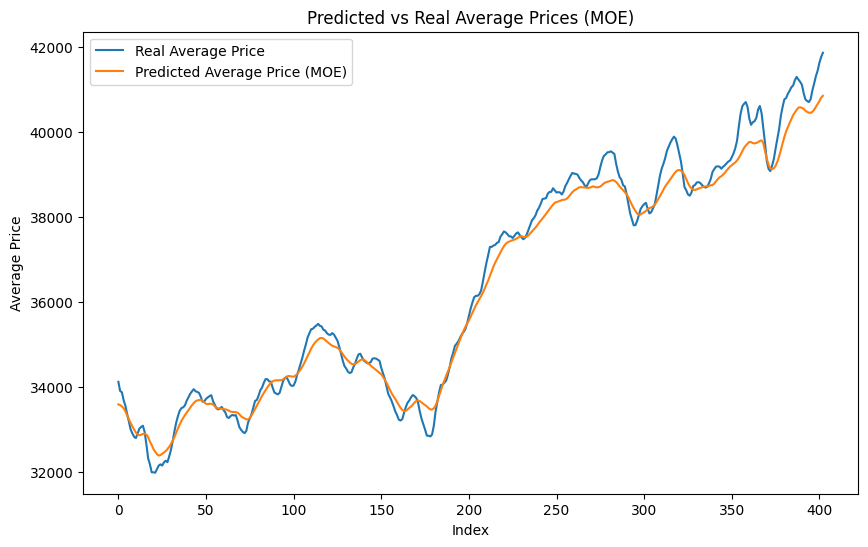

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
S&P 500 - R²: 0.7468, MAE: 207.5363, MSE: 67832.2199, RMSE: 260.4462
MAPE: 4.15%
DPA: 54.98%


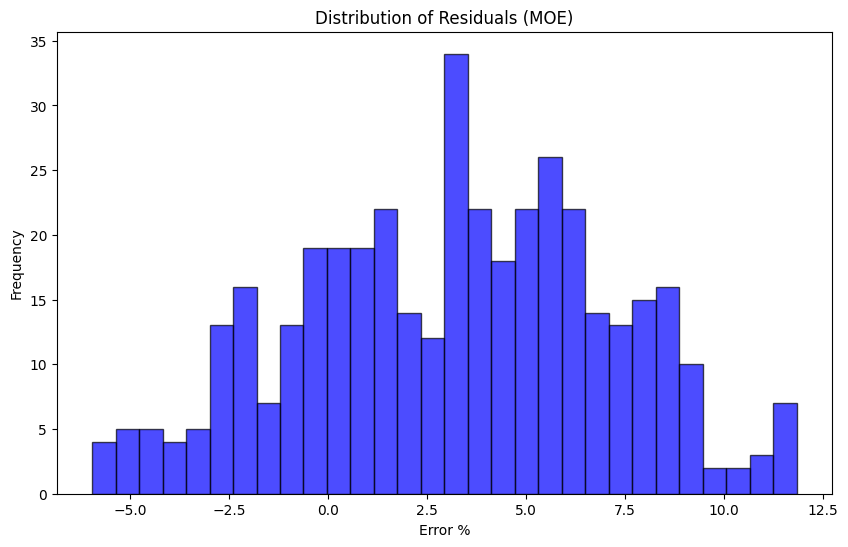

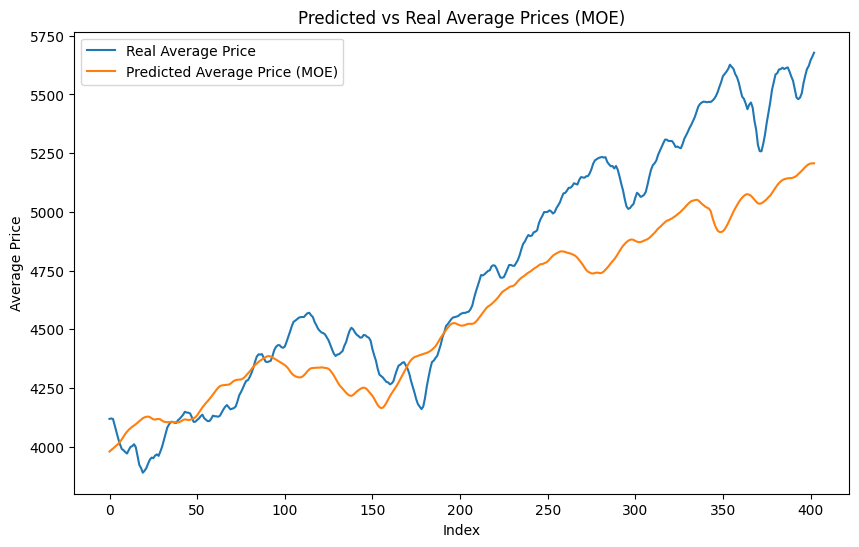

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Step 1: Data Collection
dow_jones = yf.download('^DJI', start="2023-01-01", end="2024-10-30")  # Dow Jones
sp500 = yf.download('^GSPC', start="2023-01-01", end="2024-10-30")  # S&P 500

uvxy = yf.download('UVXY', start="2023-01-01", end="2024-10-30")
vix = yf.download('^VIX', start="2023-01-01", end="2024-10-30")

# Flatten MultiIndex columns if necessary
if isinstance(dow_jones.columns, pd.MultiIndex):
    dow_jones.columns = ['_'.join(col).strip() for col in dow_jones.columns.values]
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = ['_'.join(col).strip() for col in sp500.columns.values]
if isinstance(uvxy.columns, pd.MultiIndex):
    uvxy.columns = ['_'.join(col).strip() for col in uvxy.columns.values]
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = ['_'.join(col).strip() for col in vix.columns.values]

# Select and rename relevant columns
uvxy_close_col = 'Close_UVXY' if 'Close_UVXY' in uvxy.columns else 'Adj Close_UVXY'
vix_close_col = 'Close_^VIX' if 'Close_^VIX' in vix.columns else 'Adj Close_^VIX'

uvxy = uvxy[[uvxy_close_col]].rename(columns={uvxy_close_col: 'UVXY_Close'})
vix = vix[[vix_close_col]].rename(columns={vix_close_col: 'VIX_Close'})

# Merge UVXY and VIX data with NASDAQ data
dow_jones = dow_jones.merge(uvxy, left_index=True, right_index=True, how='inner')
dow_jones = dow_jones.merge(vix, left_index=True, right_index=True, how='inner')

sp500 = sp500.merge(uvxy, left_index=True, right_index=True, how='inner')
sp500 = sp500.merge(vix, left_index=True, right_index=True, how='inner')

# Rename NASDAQ columns for easier reference
# Rename columns for easier reference
def rename_columns(df, prefix):
    return df.rename(columns={
        'Open_^DJI': f'Open_{prefix}',
        'High_^DJI': f'High_{prefix}',
        'Low_^DJI': f'Low_{prefix}',
        'Close_^DJI': f'Close_{prefix}',
        'Volume_^DJI': f'Volume_{prefix}',
        'Open_^GSPC': f'Open_{prefix}',
        'High_^GSPC': f'High_{prefix}',
        'Low_^GSPC': f'Low_{prefix}',
        'Close_^GSPC': f'Close_{prefix}',
        'Volume_^GSPC': f'Volume_{prefix}'
    }, inplace=False)

dow_jones = rename_columns(dow_jones, 'DowJones')
sp500 = rename_columns(sp500, 'SP500')

# Ensure no missing values after merging
dow_jones['UVXY_Close'] = pd.to_numeric(dow_jones['UVXY_Close'], errors='coerce').ffill().bfill()
dow_jones['VIX_Close'] = pd.to_numeric(dow_jones['VIX_Close'], errors='coerce').ffill().bfill()

sp500['UVXY_Close'] = pd.to_numeric(sp500['UVXY_Close'], errors='coerce').ffill().bfill()
sp500['VIX_Close'] = pd.to_numeric(sp500['VIX_Close'], errors='coerce').ffill().bfill()

# Step 2: Feature Preparation and Scaling
# Features for Model 1 (OHLCV + UVXY + VIX)
# Dow Jones
features_ohlcv_uvxy_vix = ['Open_DowJones', 'High_DowJones', 'Low_DowJones', 'Close_DowJones', 'Volume_DowJones', 'UVXY_Close', 'VIX_Close']
scaler_featureModel1_dow = MinMaxScaler()
scaled_features_ohlcv_dow = scaler_featureModel1_dow.fit_transform(dow_jones[features_ohlcv_uvxy_vix])

# S&P 500
features_ohlcv_uvxy_vix_sp500 = ['Open_SP500', 'High_SP500', 'Low_SP500', 'Close_SP500', 'Volume_SP500', 'UVXY_Close', 'VIX_Close']
scaler_featureModel1_sp500 = MinMaxScaler()
scaled_features_ohlcv_sp500 = scaler_featureModel1_sp500.fit_transform(sp500[features_ohlcv_uvxy_vix_sp500])

# Features for Model 2 (Technical Indicators)
dow_jones['RSI'] = ta.momentum.RSIIndicator(dow_jones['Close_DowJones'], window=14).rsi()
dow_jones['MACD'] = ta.trend.MACD(dow_jones['Close_DowJones']).macd()
bollinger = ta.volatility.BollingerBands(dow_jones['Close_DowJones'])
dow_jones['Bollinger_Upper'] = bollinger.bollinger_hband()
dow_jones['Bollinger_Lower'] = bollinger.bollinger_lband()
dow_jones['Volatility'] = dow_jones['Close_DowJones'].rolling(window=20).std()

features_tech = ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
dow_jones.dropna(inplace=True)
scaler_featureModel2_tech_dow = MinMaxScaler()
scaled_featuresModel2_tech_dow = scaler_featureModel2_tech_dow.fit_transform(dow_jones[features_tech])

# Generate Technical Indicators for S&P 500
sp500['RSI'] = ta.momentum.RSIIndicator(sp500['Close_SP500'], window=14).rsi()
sp500['MACD'] = ta.trend.MACD(sp500['Close_SP500']).macd()
bollinger_sp500 = ta.volatility.BollingerBands(sp500['Close_SP500'])
sp500['Bollinger_Upper'] = bollinger_sp500.bollinger_hband()
sp500['Bollinger_Lower'] = bollinger_sp500.bollinger_lband()
sp500['Volatility'] = sp500['Close_SP500'].rolling(window=20).std()

# Features for gates
# Shared features for Dow Jones
shared_features_dow = ['Open_DowJones', 'High_DowJones', 'Low_DowJones', 'Close_DowJones', 'Volume_DowJones',
                       'UVXY_Close', 'VIX_Close', 'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
scaler_featureGate_dow = MinMaxScaler()
scaled_features_gate_dow = scaler_featureGate_dow.fit_transform(dow_jones[shared_features_dow])

# Shared features for S&P 500
shared_features_sp500 = ['Open_SP500', 'High_SP500', 'Low_SP500', 'Close_SP500', 'Volume_SP500',
                         'UVXY_Close', 'VIX_Close', 'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
scaler_featureGate_sp500 = MinMaxScaler()
scaled_features_gate_sp500 = scaler_featureGate_sp500.fit_transform(sp500[shared_features_sp500])

# Target variable for Dow Jones
dow_jones['Target'] = dow_jones['Close_DowJones'].shift(-5).rolling(window=5, min_periods=1).mean()
dow_jones.dropna(subset=['Target'], inplace=True)
scaler_y_dow = MinMaxScaler()
dow_jones['Target'] = scaler_y_dow.fit_transform(dow_jones[['Target']])

# Target variable for S&P 500
sp500['Target'] = sp500['Close_SP500'].shift(-5).rolling(window=5, min_periods=1).mean()
sp500.dropna(subset=['Target'], inplace=True)
scaler_y_sp500 = MinMaxScaler()
sp500['Target'] = scaler_y_sp500.fit_transform(sp500[['Target']])


# Step 3: Create Sequences
sequence_length = 30

def create_sequences(features, target, sequence_length):
    valid_length = min(len(features), len(target)) - sequence_length
    features = features[:valid_length + sequence_length]
    target = target[:valid_length]

    X, y = [], []
    for i in range(valid_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i])
    return np.array(X), np.array(y)

# Sequences for Dow Jones
X_ohlcv_dow, y_dow = create_sequences(scaled_features_ohlcv_dow, dow_jones['Target'].values, sequence_length)
X_tech_dow, _ = create_sequences(scaled_featuresModel2_tech_dow, dow_jones['Target'].values, sequence_length)
X_gate_dow, _ = create_sequences(scaled_features_gate_dow, dow_jones['Target'].values, sequence_length)

# Sequences for S&P 500
X_ohlcv_sp500, y_sp500 = create_sequences(scaled_features_ohlcv_sp500, sp500['Target'].values, sequence_length)
X_tech_sp500, _ = create_sequences(scaled_featuresModel2_tech_sp500, sp500['Target'].values, sequence_length)
X_gate_sp500, _ = create_sequences(scaled_features_gate_sp500, sp500['Target'].values, sequence_length)

# Test the gating network
pred1_test_dow = model1_dow.predict(X_ohlcv_dow)
pred2_test_dow = model2_dow.predict(X_tech_dow)
gating_weights_test_dow = gating_model.predict(X_gate_dow)

# Combine predictions using gating network weights
final_predictions_dow = gating_weights_test_dow[:, 0:1] * pred1_test_dow + gating_weights_test_dow[:, 1:2] * pred2_test_dow

# Inverse transform test predictions
predictions_original_dow = scaler_y_dow.inverse_transform(final_predictions_dow)
y_test_original_dow = scaler_y_dow.inverse_transform(y_dow.reshape(-1, 1))

# Mask for non-NaN values
predictions_original_dow = predictions_original_dow.squeeze()
valid_mask = ~np.isnan(y_test_original_dow[:2713, 0]) & ~np.isnan(predictions_original_dow)

# Apply the mask to both arrays
filtered_y_test = y_test_original_dow[:2713, 0][valid_mask]
filtered_predictions = predictions_original_dow[valid_mask]

mse_dow = mean_squared_error(y_test_original_dow, predictions_original_dow)
rmse_dow = np.sqrt(mse_dow)
r2_dow = r2_score(y_test_original_dow, predictions_original_dow)
mae_dow = mean_absolute_error(y_test_original_dow, predictions_original_dow)

# Calculate MAPE
mape_dow = np.mean(np.abs((filtered_y_test - filtered_predictions) / filtered_y_test)) * 100
residual_dow = (filtered_y_test - filtered_predictions) / filtered_y_test * 100

# Calculate DPA
real_direction = np.sign(np.diff(filtered_y_test))  # Actual direction (+1 for up, -1 for down, 0 for no change)
predicted_direction = np.sign(np.diff(filtered_predictions))  # Predicted direction

# Compare the directions
correct_directions = real_direction == predicted_direction

# Calculate the percentage of correct directions
dpa_dow = np.sum(correct_directions) / len(correct_directions) * 100

print(f"Dow Jones - R²: {r2_dow:.4f}, MAE: {mae_dow:.4f}, MSE: {mse_dow:.4f}, RMSE: {rmse_dow:.4f}")
print(f"MAPE: {mape_dow:.2f}%")
print(f"DPA: {dpa_dow:.2f}%")

# Residual Distribution
plt.figure(figsize=(10, 6))
plt.hist(residual_dow, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Residuals (MOE)")
plt.xlabel("Error %")
plt.ylabel("Frequency")
plt.show()

# Plot Real and Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(filtered_y_test, label='Real Average Price')
plt.plot(filtered_predictions, label='Predicted Average Price (MOE)')
plt.legend()
plt.title("Predicted vs Real Average Prices (MOE)")
plt.xlabel("Index")
plt.ylabel("Average Price")
plt.show()

# Test the gating network
pred1_test_sp500 = model1_sp500.predict(X_ohlcv_sp500)
pred2_test_sp500 = model2_sp500.predict(X_tech_sp500)
gating_weights_test_sp500 = gating_model.predict(X_gate_sp500)

# Combine predictions using gating network weights
pred1_test_sp500_col = pred1_test_sp500[:2713, 0].reshape(-1, 1)
final_predictions_sp500 = gating_weights_test_sp500[:2713, 0:1] * pred1_test_sp500_col + gating_weights_test_sp500[:2713, 1:2] * pred2_test_sp500

# Inverse transform test predictions
predictions_original_sp500 = scaler_y_sp500.inverse_transform(final_predictions_sp500)
y_test_original_sp500 = scaler_y_sp500.inverse_transform(y_sp500.reshape(-1, 1))

# Mask for non-NaN values
predictions_original_sp500 = predictions_original_sp500.squeeze()
valid_mask = ~np.isnan(y_test_original_sp500[:2713, 0]) & ~np.isnan(predictions_original_sp500)

# Apply the mask to both arrays
filtered_y_test = y_test_original_sp500[:2713, 0][valid_mask]
filtered_predictions = predictions_original_sp500[valid_mask]

mse_sp500 = mean_squared_error(filtered_y_test, filtered_predictions)
rmse_sp500 = np.sqrt(mse_sp500)
r2_sp500 = r2_score(filtered_y_test, filtered_predictions)
mae_sp500 = mean_absolute_error(filtered_y_test, filtered_predictions)

# Calculate MAPE
mape_sp500 = np.mean(np.abs((filtered_y_test - filtered_predictions) / filtered_y_test)) * 100
residuel_sp500 = (filtered_y_test - filtered_predictions) / filtered_y_test * 100

# Calculate DPA
real_direction = np.sign(np.diff(filtered_y_test))  # Actual direction (+1 for up, -1 for down, 0 for no change)
predicted_direction = np.sign(np.diff(filtered_predictions))  # Predicted direction

# Compare the directions
correct_directions = real_direction == predicted_direction

# Calculate the percentage of correct directions
dpa_sp500 = np.sum(correct_directions) / len(correct_directions) * 100

print(f"S&P 500 - R²: {r2_sp500:.4f}, MAE: {mae_sp500:.4f}, MSE: {mse_sp500:.4f}, RMSE: {rmse_sp500:.4f}")
print(f"MAPE: {mape_sp500:.2f}%")
print(f"DPA: {dpa_sp500:.2f}%")

# Residual Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuel_sp500, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Residuals (MOE)")
plt.xlabel("Error %")
plt.ylabel("Frequency")
plt.show()

# Plot Real and Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(filtered_y_test, label='Real Average Price')
plt.plot(filtered_predictions, label='Predicted Average Price (MOE)')
plt.legend()
plt.title("Predicted vs Real Average Prices (MOE)")
plt.xlabel("Index")
plt.ylabel("Average Price")
plt.show()